In [21]:
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array

from pandas.plotting import bootstrap_plot
import numpy as np
import pandas as pd
import bcolz
import threading

import cv2

from utils import *

import os
import sys
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [22]:
dataset1 = pd.read_csv('dataset/target.csv')
dataset1['imgpath'] = dataset1.id.apply(file_path_from_db_id)

In [189]:
def batch_generator(df, batch_size, target_size, target_column='target', features=None, process=True, shuffle=True):

    nbatches, n_skipped_per_epoch = divmod(df.shape[0], batch_size)
    #print nbatches
    count = 1
    epoch = 0
    # New epoch.
    while 1:
        if shuffle:
            df = df.sample(frac=1) # shuffle in every epoch
        
        epoch += 1
        i, j = 0, batch_size
        # Mini-batches within epoch.
        mini_batches_completed = 0
        for _ in range(nbatches):
            sub = df.iloc[i:j]
            try:
                if process == True:
                    X = np.array([(2 * (img_to_array(load_img(f, target_size=target_size)) / 255.0 - 0.5)) for f in sub.imgpath])
                else:
                    X = np.array([((img_to_array(load_img(f, target_size=target_size)))) for f in sub.imgpath])
                    
                Y = sub[target_column].values
                # Simple model, one input, one output.
                mini_batches_completed += 1
                yield X, Y

            except IOError as err:
                count -= 1

            i = j
            j += batch_size
            count += 1

(array([0.37864316]), array([-0.37864316]))


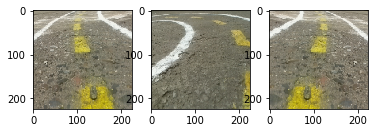

In [217]:
datagen = ImageDataGenerator(
        rotation_range=20,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        fill_mode='nearest')


test_gen = batch_generator(dataset1, 1, (224,224), 'angular', process=False, shuffle=False)
img, tg = test_gen.next()
img = img[0]
img = (img)*255
plt.subplot(131)
plt.imshow(img)

for i, row in dataset1.sample(1).iterrows():
    img3 = img_to_array(load_img(row['imgpath']))
#rImg = datagen.flow(img.reshape((1,) + img.shape),y=None, batch_size=1).next()
#print rImg.shape
plt.subplot(132)
plt.imshow(img3*255)

img2, tg2 = horizontal_flip(img, tg)
plt.subplot(133)
plt.imshow(img2)

print(tg, tg2)

In [233]:
datagen = ImageDataGenerator(
        rotation_range=20,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        fill_mode='nearest')

test_gen = batch_generator(dataset1, 1, (224,224), 'angular', process=False, shuffle=False)

offset = dataset1.shape[0] + 1
id_offset = dataset1['id'].max() + 1
i = 0
newData = []
for idx, row in dataset1.iterrows():
    # generador auxiliar
    
    ### extraemos la imagen en una variable auxiliar
    img = img_to_array(load_img(row['imgpath']))
    target = row['angular']
    ### aplicamos la transformacion de acuerdo a ciertas condiciones
    ## si es cero, o muy cercano a 0 no aplicamos la transformacion
    if np.abs(target) > 0.09:
        ## transformacion horizontal
        hImg, hTarget = horizontal_flip(img, target) 
        # guardar imagen y entry en el dataframe
        filename = "dataset/" + str(id_offset + i) + ".bmp";
        hImg = cv2.cvtColor(hImg,cv2.COLOR_BGR2RGB)
        cv2.imwrite(filename, hImg)
        newData.append([(id_offset + i), 
                        row['linear'], 
                        hTarget,
                        filename])
        # incrementa indice para siguiente entrada
        i += 1
        
        ## transformacion aleatoria
        choice = np.random.choice([0,1])
        if choice == 1:
            rImg = datagen.flow(img.reshape((1,) + img.shape),y=None, batch_size=1).next()
            rImg = rImg[0]
            # guardar imagen y entry en el dataframe
            filename = "dataset/" + str(id_offset + i) + ".bmp";
            rImg = cv2.cvtColor(rImg,cv2.COLOR_BGR2RGB)
            cv2.imwrite(filename, rImg)
            newData.append([(id_offset + i), 
                            row['linear'], 
                            target,
                            filename])
            # incrementa indice para siguiente entrada
            i += 1
        
        
        
    ### guardamos la imagen en el directorio y el nuevo target en el d
columns = ['id', 'linear', 'angular', 'imgpath']
newDataset = pd.DataFrame(newData, columns=columns)

In [16]:
newDataset = pd.DataFrame(newData, columns=columns)

In [235]:
newDataset.tail()

,id,linear,angular,imgpath
14554,27256,0.0,0.133885,dataset/27256.bmp
14555,27257,0.0,-0.133885,dataset/27257.bmp
14556,27258,0.0,0.133885,dataset/27258.bmp
14557,27259,0.0,-0.133885,dataset/27259.bmp
14558,27260,0.0,0.133885,dataset/27260.bmp


In [236]:
dataset = dataset1.append(newDataset, ignore_index=True)

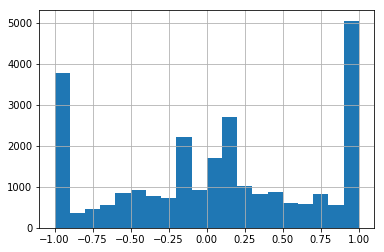

In [238]:
dataset.angular.hist(bins=20)

In [242]:

dataset.tail()


,angular,id,imgpath,linear,target
26351,0.133885,27256,dataset/27256.bmp,0.0,NaN
26352,-0.133885,27257,dataset/27257.bmp,0.0,NaN
26353,0.133885,27258,dataset/27258.bmp,0.0,NaN
26354,-0.133885,27259,dataset/27259.bmp,0.0,NaN
26355,0.133885,27260,dataset/27260.bmp,0.0,NaN


In [243]:
dataset.to_csv('augmented.csv')